# Libraries & Settings

In [354]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [570]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import (
    data_files,
    load_bin,
    store_bin,
    load_csv,
    write_xlsx,
    load_xlsx,
    set_project_dir,
    project_dir,
)
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words, normalize_rows, clear_row_max
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [356]:
set_project_dir("vkprog")

## Buchungsdaten

In [357]:
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-09-17 17:14:37 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_data.feather
INFO:pa_log:Reading from file C:\Users\kpf\data\vkprog\bd_data.feather
2019-09-17 17:14:38 [INFO] Finished loading binary file in 0.16s (0.84s CPU)
INFO:pa_log:Finished loading binary file in 0.16s (0.84s CPU)


In [358]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/668346,31966
Endkunde,category,0/668346,30050
EK_Abc,category,1155/667191,8
EK_Boni,category,76/668270,3
EK_Plz,category,165/668181,2954
EK_Ort,category,165/668181,3006
EK_Land,category,165/668181,45
EK_HB_Apg_Kurzz,category,27659/640687,90
EK_Kam_Betreut,int64,0/668346,2
EK_Aktiv,int64,0/668346,2


## Dispo dates

In [359]:
dispo = load_bin("dispo.feather").set_index('Dispo')
dispo.head()

2019-09-17 17:14:47 [INFO] Reading from file C:\Users\kpf\data\vkprog\dispo.feather
INFO:pa_log:Reading from file C:\Users\kpf\data\vkprog\dispo.feather
2019-09-17 17:14:47 [INFO] Finished loading binary file in 0.0s (0.05s CPU)
INFO:pa_log:Finished loading binary file in 0.0s (0.05s CPU)


,KAM_open_date,open_date,Jahr,KAM_KW_2,KW_2
Dispo,,,,,
2006-2,2006-04-03,2006-04-10,2006,13,15
2007-1,2006-10-02,2006-10-09,2006,39,41
2007-2,2007-04-02,2007-04-09,2007,13,15
2008-1,2007-10-08,2007-10-15,2007,41,41
2008-2,2008-04-07,2008-04-14,2008,15,15


In [360]:
dispo_periods = load_bin("dispo_periods.feather").set_index('Jahr')
dispo_periods

2019-09-17 17:14:51 [INFO] Reading from file C:\Users\kpf\data\vkprog\dispo_periods.feather
INFO:pa_log:Reading from file C:\Users\kpf\data\vkprog\dispo_periods.feather
2019-09-17 17:14:51 [INFO] Finished loading binary file in 0.0s (0.0s CPU)
INFO:pa_log:Finished loading binary file in 0.0s (0.0s CPU)


,KAM_1,Alle_1,KAM_2,Alle_2
Jahr,,,,
2006,13,15,39,41
2007,13,15,41,41
2008,15,15,41,41
2009,15,15,41,41
2010,13,15,39,41
2011,7,9,39,41
2012,13,15,39,41
2013,13,15,39,41
2014,13,15,39,41


## Endkunden Information

In [361]:
ek_info = load_bin('ek_info.feather').drop(columns='index')

2019-09-17 17:14:55 [INFO] Reading from file C:\Users\kpf\data\vkprog\ek_info.feather
INFO:pa_log:Reading from file C:\Users\kpf\data\vkprog\ek_info.feather
2019-09-17 17:14:55 [INFO] Finished loading binary file in 0.03s (0.05s CPU)
INFO:pa_log:Finished loading binary file in 0.03s (0.05s CPU)


In [362]:
desc_col(ek_info)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/31966,31966
Endkunde,object,0/31966,30050
EK_Aktiv,int64,0/31966,2
EK_Kam_Betreut,int64,0/31966,2
EK_Land,object,49/31917,45
PLZ,int64,0/31966,2865
NAME,object,49/31917,2993
Agentur,object,20828/11138,3222
EK_BG,object,1804/30162,83
EK_BG_ID,object,1804/30162,83


In [363]:
ek_info.head(10)

,Endkunde_NR,Endkunde,EK_Aktiv,EK_Kam_Betreut,EK_Land,PLZ,NAME,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Last_Res_Date,First_Res_Year,Last_Res_Year,Last_Aus_Date,KANTON,BEZIRK,REGION,GROSSREGION
0,100034,Maurer + Salzmann AG,1,0,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2018-10-31,2009,2018,2018-11-12,ZH,Winterthur,Winterthur,Region Zürich
1,100039,Bank BSU Genossenschaft,1,0,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2019-09-01,2009,2019,2019-12-01,ZH,Uster,Uster–Dübendorf,Region Zürich
2,100061,Mundwiler Juwelen AG,1,0,SCHWEIZ,8400,Winterthur,None,WG - Persönlicher Bedarf,555,555,1,2009-09-16,2009,2009,2009-10-12,ZH,Winterthur,Winterthur,Region Zürich
3,100064,Senn Communication,1,0,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"901,960",2,2017-03-09,2009,2017,2017-07-01,ZH,Uster,Uster–Dübendorf,Region Zürich
4,100066,"walder, werber werbeagentur ag",1,0,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"780,720",2,2018-09-13,2013,2018,2018-10-01,ZH,Uster,Uster–Dübendorf,Region Zürich
5,100083,Goodyear Dunlop Tires Suisse SA,1,0,SCHWEIZ,8604,Volketswil,a.ha GmbH,WG - Fahrzeugzubehör,390,390,1,2019-06-12,2011,2019,2019-09-30,ZH,Uster,Uster–Dübendorf,Region Zürich
6,100092,Navyboot AG,1,1,SCHWEIZ,8001,Zürich,Kinetic Worldwide Switzerland AG,WG - Bekleidung / Wäsche,195,195,1,2015-12-09,2009,2015,2016-03-28,ZH,Zürich,Zürich,Region Zürich
7,100095,Zomag AG,1,0,SCHWEIZ,8620,Wetzikon ZH,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,720,1,2019-08-02,2009,2019,2019-08-12,ZH,Hinwil,Wetzikon (ZH),Region Zürich
8,100097,Biomed AG,1,1,SCHWEIZ,8600,Dübendorf,mediaschneider ag,WG - Pharma Produkte,366,"366,800,720",3,2018-12-14,2009,2018,2019-01-16,ZH,Uster,Uster–Dübendorf,Region Zürich
9,100098,Maison Astor Coiffure GmbH,1,0,SCHWEIZ,8304,Wallisellen,None,WG - Haarpflege,332,"332,334",2,2018-10-01,2008,2018,2018-12-31,ZH,Bülach,Uster–Dübendorf,Region Zürich


### How many customers started or ended in which year?

In [364]:
pd.crosstab(
    index=ek_info.First_Res_Year,
    columns=ek_info.Last_Res_Year,
    margins=True,
)

Last_Res_Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
First_Res_Year,,,,,,,,,,,,,
2007,0,3,0,0,1,0,1,0,0,0,2,2,9
2008,265,145,105,86,84,94,98,117,111,94,274,645,2118
2009,0,1611,510,345,292,306,251,297,259,277,480,1390,6018
2010,0,0,1242,275,188,144,126,129,98,125,227,377,2931
2011,0,0,0,1308,243,172,136,166,125,123,193,395,2861
2012,0,0,0,0,1124,228,153,146,163,111,163,281,2369
2013,0,0,0,0,0,1128,260,160,144,137,195,305,2329
2014,0,0,0,0,0,0,1183,267,185,138,218,367,2358
2015,0,0,0,0,0,0,0,1366,283,199,240,350,2438


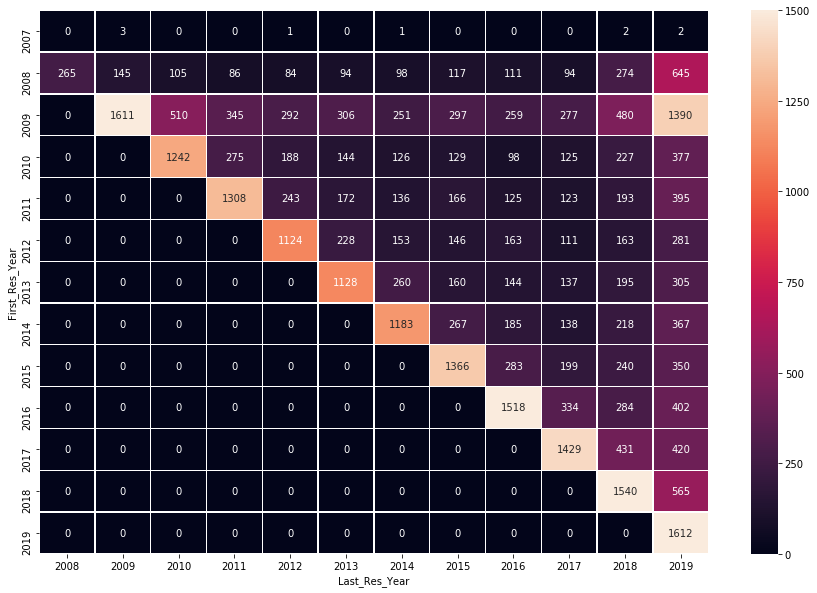

In [365]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.crosstab(
    index=ek_info.First_Res_Year, columns=ek_info.Last_Res_Year
)

plt.figure(figsize=(15, 10))
sns.heatmap(data=plot_data, linewidths=0.3, vmax=1500, annot=True, fmt="d")

# Distribution of Auftragsart

In [366]:
display(
    pd.crosstab(
        index=[bd.Auftragsart, bd.Vertrag], columns=bd.Kamp_Erfass_Jahr, margins=True
    )
)
display("Netto-Umsatz")
display(
    bd.pivot_table(
        index=["Auftragsart", "Vertrag"],
        columns="Kamp_Erfass_Jahr",
        values="Netto",
        aggfunc="sum",
        fill_value=0,
        margins=True,
    )
)

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,88,2003,1629,1745,2223,2703,1488,26,14,16,21,17,11973
Eigenwerbung APG,Nein,0,0,79,0,1,13,0,1,123,56,82,56,0,411
Goodwill,Nein,0,0,6,7,6,9,9,5,6,4,12,13,7,84
Karitativ,Nein,0,104,227,238,224,351,265,304,442,564,547,598,402,4266
Kommerziell,Nein,0,6078,34516,38627,39748,37761,36611,40953,43260,48152,50064,48949,37380,462099
Logistik für Dritte,Nein,0,0,0,0,4,13,6,31,387,353,371,378,284,1827
Politisch,Nein,0,354,1934,1773,4847,3068,2492,2733,5842,3536,3106,3275,4428,37388
Promotion,Nein,0,60,2283,1879,1728,1823,3048,1212,2102,2736,2965,3854,628,24318
Sponsoring,Nein,0,40,139,124,179,181,171,172,218,208,245,358,101,2136


'Netto-Umsatz'

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,30444,849600,791206,739514,1026394,1000669,439344,110412,92214,117954,150966,98892,5447609
Eigenwerbung APG,Nein,0,0,3897655,0,4670,1048532,0,360,133390,126540,1222454,72427,0,6506028
Goodwill,Nein,0,0,6543,7939,4953,18668,2994,4762,4191,1732,17772,16741,6391,92686
Karitativ,Nein,0,724644,1960077,1628917,1866012,2668615,2253943,2318474,2578634,3459117,2775404,3962032,2568308,28764177
Kommerziell,Nein,0,33806952,148051046,162393013,168628594,175031787,158519973,182560236,193519765,204222602,197001081,191220793,147012790,1961968632
Logistik für Dritte,Nein,0,0,0,0,4600,184578,31589,132394,479850,420927,418245,522661,329072,2523916
Politisch,Nein,0,2040430,6938949,6463858,18562173,11082670,9945225,10458567,16977360,11414298,6379246,8489070,10508317,119260163
Promotion,Nein,0,1083041,5375644,4376195,3393104,3505266,5451654,3185928,3787542,4991362,4881049,9304271,1665755,51000811
Sponsoring,Nein,0,348746,1097029,1087749,2340803,2588788,3282531,3450304,3740079,3906123,3671259,3424984,859168,29797563


### Auftragsart vs. customers

In [367]:
%%time

ek_auftragsart = pd.crosstab(columns=bd.Auftragsart, index=bd.Endkunde_NR)
ek_auftragsart.mask(ek_auftragsart == 0, inplace=True)

ek_auftragsart.head(10)

Wall time: 2.3 s


Auftragsart,Aushangauftrag Partner,Eigenwerbung APG,Goodwill,Karitativ,Kommerziell,Logistik für Dritte,Politisch,Promotion,Sponsoring,Traffic Auftrag,Vertragsvorschrift (OC),langfristiger Vertrag
Endkunde_NR,,,,,,,,,,,,
100034,NaN,NaN,NaN,NaN,119.0,NaN,NaN,13.0,NaN,18.0,NaN,NaN
100039,NaN,NaN,NaN,NaN,50.0,NaN,NaN,1.0,NaN,17.0,NaN,NaN
100061,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100064,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,9.0,NaN,NaN
100066,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100083,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100092,NaN,NaN,NaN,NaN,27.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
100095,NaN,NaN,NaN,NaN,112.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN
100097,NaN,NaN,NaN,NaN,144.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN


How many **different** Auftragsart per customer?

In [368]:
ek_auftragsart.count(axis='columns').value_counts()

1    23894
2     5864
3     1776
4      384
5       35
6       10
7        2
8        1
dtype: int64

How many **most frequent** Auftragsart per customer? 

In [369]:
(ek_auftragsart.subtract(ek_auftragsart.max(axis='columns'), axis='index') == 0).sum(axis='columns').value_counts()

1    31205
2      741
3       20
dtype: int64

Where is the a **clear favourite** Auftragsart for a customer?

In [370]:
%%time
ek_auftragsart_scores = clear_row_max(ek_auftragsart)

Wall time: 21.7 s


In [371]:
ek_auftragsart_scoring = pd.DataFrame(
    index=ek_auftragsart_scores.index,
    data={"AufArt": ek_auftragsart_scores},
)

ek_auftragsart_scoring.dropna(inplace=True)

# Branchen

In [372]:
ek_branchen = ek_info.loc[:,['Endkunde_NR', 'EK_BG_ID', 'Auftrag_BG_ID']].copy()

In [373]:
def unique_list(lst):
    return list(set(lst))


ek_branchen["Auftrag_BG_list"] = ek_branchen.Auftrag_BG_ID.str.split(",")
ek_branchen["BG_list"] = ek_branchen.apply(
    lambda x: unique_list([x.EK_BG_ID] + x.Auftrag_BG_list), axis="columns"
)
ek_branchen.drop(
    ["EK_BG_ID", "Auftrag_BG_ID", "Auftrag_BG_list"], axis="columns", inplace=True
)

In [374]:
display(ek_branchen.head())

ek_branchen_scoring = ek_branchen.explode(column="BG_list").rename(
    columns={"BG_list": "BG"}
)

display(ek_branchen_scoring.head())

,Endkunde_NR,BG_list
0,100034,"[400, 295, 405, 720]"
1,100039,"[470, 720]"
2,100061,[555]
3,100064,"[901, 720, 960]"
4,100066,"[780, 720]"


,Endkunde_NR,BG
0,100034,400
0,100034,295
0,100034,405
0,100034,720
1,100039,470


# Auftragsart vs. Branchen

In [375]:
AufArt_BG = ek_auftragsart_scoring.merge(ek_branchen_scoring, how='inner', on='Endkunde_NR')

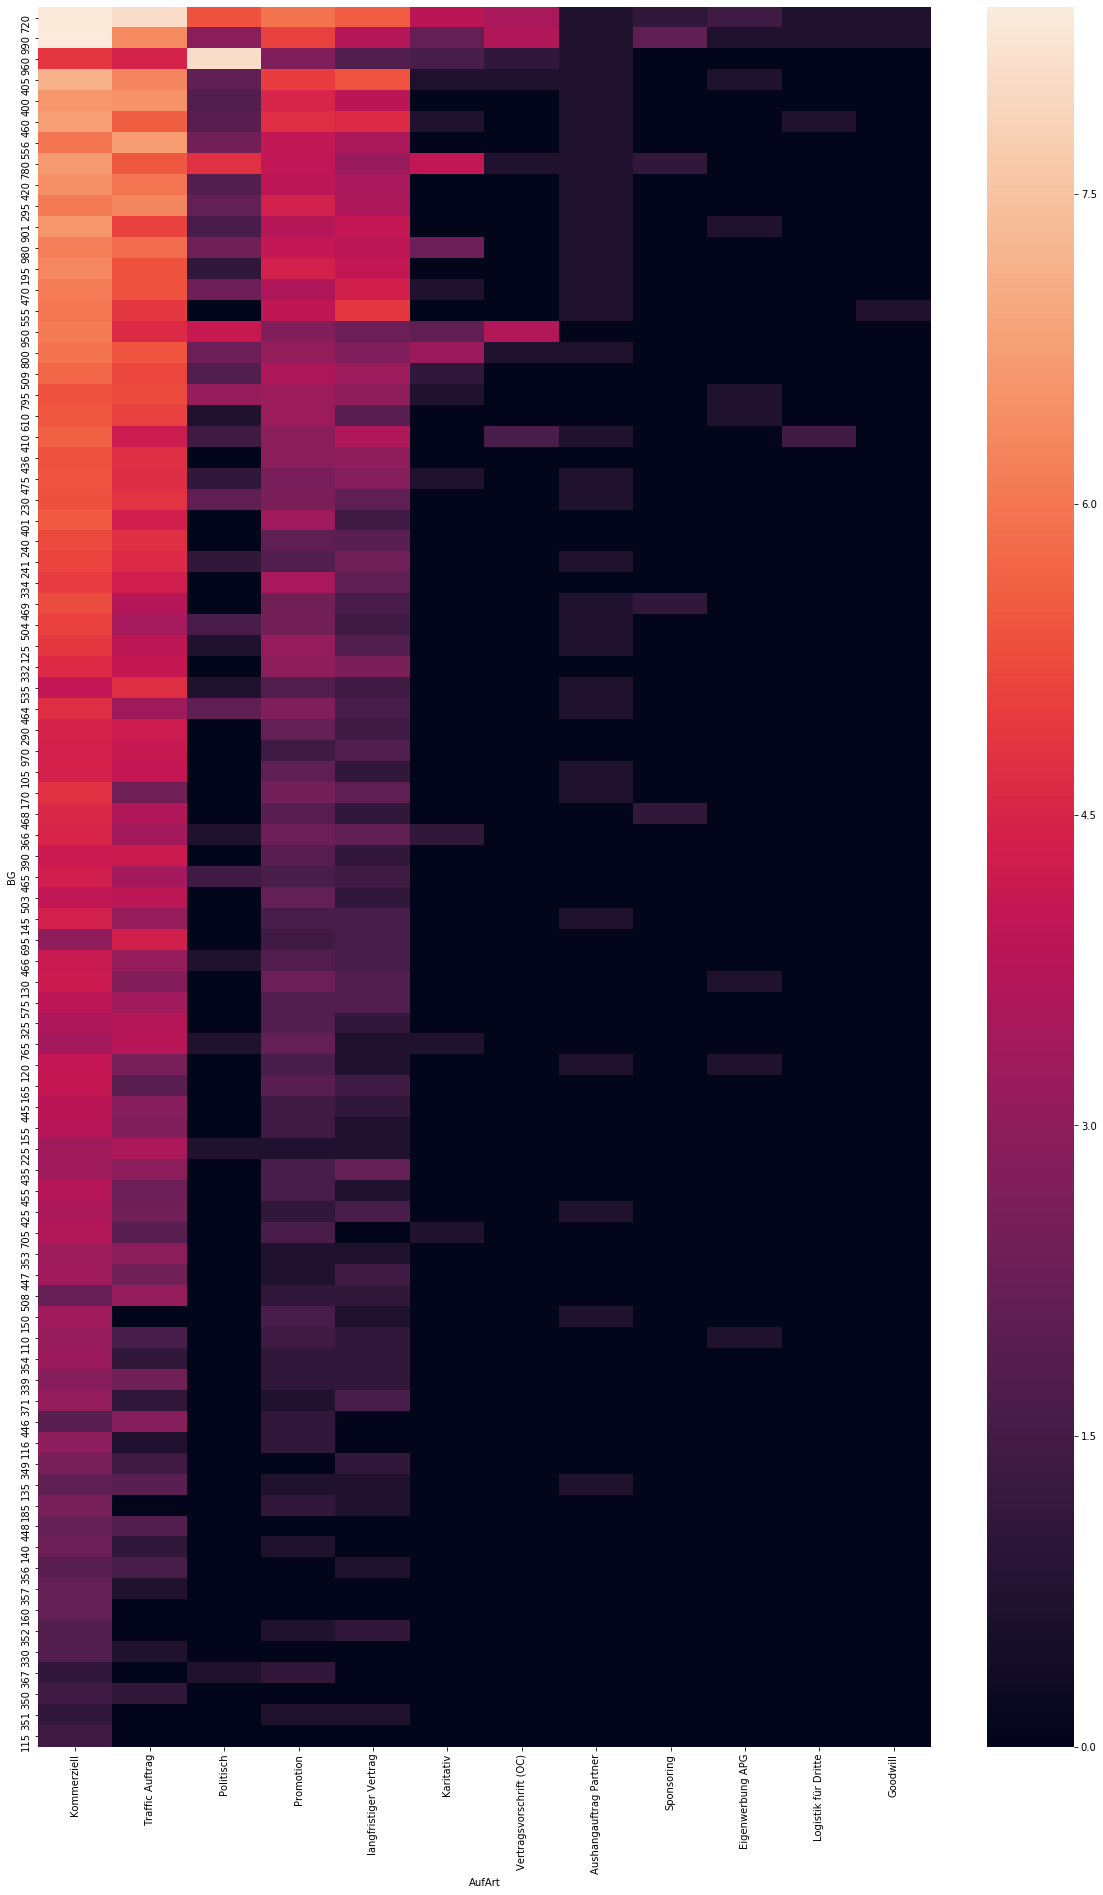

In [376]:
plt.figure(figsize=(20, 32))
sns.heatmap(
    data=np.log1p(
        pd.crosstab(columns=AufArt_BG.AufArt, index=AufArt_BG.BG, margins=True)
        .sort_values("All", ascending=False)
        .sort_values("All", axis="columns", ascending=False)
    ).iloc[1:,1:]
)

In [377]:
display(
    normalize_rows(
        pd.crosstab(columns=AufArt_BG.AufArt, index=AufArt_BG.BG, margins=True)
        .sort_values("All", ascending=False)
        .sort_values("All", axis="columns", ascending=False)
        .iloc[1:, 1:]
    )
)

AufArt,Kommerziell,Traffic Auftrag,Politisch,Promotion,langfristiger Vertrag,Karitativ,Vertragsvorschrift (OC),Aushangauftrag Partner,Sponsoring,Eigenwerbung APG,Logistik für Dritte,Goodwill
BG,,,,,,,,,,,,
720,0.501389,0.387218,0.025734,0.045065,0.030083,0.005678,0.003866,0.000121,0.000242,0.000362,0.000121,0.000121
990,0.841657,0.108021,0.003216,0.028944,0.007567,0.001513,0.007000,0.000189,0.001324,0.000189,0.000189,0.000189
960,0.037101,0.024058,0.931304,0.004058,0.001449,0.001159,0.000580,0.000290,0.000000,0.000000,0.000000,0.000000
405,0.580241,0.243506,0.003247,0.069573,0.101577,0.000464,0.000464,0.000464,0.000000,0.000464,0.000000,0.000000
400,0.467878,0.439974,0.003245,0.057755,0.030500,0.000000,0.000000,0.000649,0.000000,0.000000,0.000000,0.000000
460,0.641256,0.194320,0.004484,0.082960,0.074738,0.000747,0.000000,0.000747,0.000000,0.000000,0.000747,0.000000
556,0.297297,0.627799,0.007722,0.040927,0.025483,0.000000,0.000000,0.000772,0.000000,0.000000,0.000000,0.000000
780,0.613690,0.187254,0.092840,0.041699,0.018883,0.042486,0.000787,0.000787,0.001574,0.000000,0.000000,0.000000
420,0.577578,0.345291,0.004484,0.043049,0.028700,0.000000,0.000000,0.000897,0.000000,0.000000,0.000000,0.000000


# Restrict bookings to interesting customers (current & long-term)

### List of current long-time customers

* "Current" means that their last booking was not more than two years back. 
* "Long-time" means that they had at least two years of bookings.

In [378]:
limit_year = pd.Timestamp.today().year - 2

ek_nr_current = ek_info.loc[
    (ek_info.Last_Res_Year >= limit_year)
    & (ek_info.First_Res_Year < limit_year - 2),
    "Endkunde_NR"
]

In [379]:
bd_current = (
    bd.loc[bd.Endkunde_NR.isin(ek_nr_current)].pipe(clean_up_categoricals).copy()
)

print(f"Keeping {bd_current.shape[0]} of {bd.shape[0]} records")

Keeping 465681 of 668346 records


In [380]:
ek_info_current = ek_info.loc[ek_info.Endkunde_NR.isin(ek_nr_current)].copy()

print(f"Keeping {ek_info_current.shape[0]} of {ek_info.shape[0]} records")

Keeping 6519 of 31966 records


# Aggregate bookings per customer, year, and KW_2 / KW_4 period

Both by Reservation and Aushang.

In [381]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )

    return df_aggr

In [462]:
bd_aggr_2w = aggregate_bookings(bd_current, 'KW_2')
bd_aggr_4w = aggregate_bookings(bd_current, 'KW_4')

2019-09-18 09:36:48 [INFO] Period: KW_2
INFO:pa_log:Period: KW_2
2019-09-18 09:36:48 [INFO] Calculate Reservation...
INFO:pa_log:Calculate Reservation...
2019-09-18 09:36:48 [INFO] Calculate Aushang...
INFO:pa_log:Calculate Aushang...
2019-09-18 09:36:48 [INFO] Merge Results...
INFO:pa_log:Merge Results...
2019-09-18 09:36:49 [INFO] Period: KW_4
INFO:pa_log:Period: KW_4
2019-09-18 09:36:49 [INFO] Calculate Reservation...
INFO:pa_log:Calculate Reservation...
2019-09-18 09:36:49 [INFO] Calculate Aushang...
INFO:pa_log:Calculate Aushang...
2019-09-18 09:36:49 [INFO] Merge Results...
INFO:pa_log:Merge Results...


In [383]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus
0,103092,2007,45,5310.0,0.0
1,116266,2007,23,5700.0,0.0
2,177225,2007,45,2365.0,0.0
3,494878,2007,47,5900.0,0.0
4,100098,2008,39,16755.0,0.0
5,100143,2008,39,15000.0,0.0
6,100143,2008,49,2560.0,0.0
7,100166,2008,47,1007.0,0.0
8,100166,2008,49,40823.0,0.0
9,100166,2008,51,10431.0,1007.0


# Drop incomplete years

We have data for the last 10 years, the current year is incomplete

In [580]:
current_year = pd.Timestamp.today().year
complete_years = list(range(current_year - 10, current_year))
print(complete_years)

bd_aggr_2w_complete = bd_aggr_2w.Jahr.isin(complete_years)

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


# Enrich with distance from closest/last dispo opening

* Flag KAM customers (they have their own dispo openings!)
* Add dispo openings for each year, including D2 of previous year and D1 of next year

In [463]:
bd_aggr_2w = (
    bd_aggr_2w.assign(
        KAM_Kunde=bd_aggr_2w.merge(ek_info, how="left", on="Endkunde_NR")[
            "EK_Kam_Betreut"
        ].values,
        last_year=bd_aggr_2w.Jahr - 1,
        next_year=bd_aggr_2w.Jahr + 1,
    )
    .merge(dispo_periods.astype("float").reset_index(), how="left", on="Jahr")
    .merge(
        np.subtract(
            dispo_periods[["KAM_2", "Alle_2"]].astype("float"), 52
        ).reset_index(),
        how="left",
        left_on="last_year",
        right_on="Jahr",
        suffixes=("", "_last"),
    )
    .merge(
        np.add(dispo_periods[["KAM_1", "Alle_1"]].astype("float"), 52).reset_index(),
        how="left",
        left_on="next_year",
        right_on="Jahr",
        suffixes=("", "_next"),
    )
).drop(columns=["last_year", "Jahr_last", "next_year", "Jahr_next"])

In [464]:
KAM = bd_aggr_2w.KAM_Kunde == 1
ALLE = ~KAM

Calculate distances to all relevant dispo opening periods

In [465]:
def dist_calc(df, rows, dist_cols, ref_cols):
    for (dist_col, dispo_col) in zip(dist_cols, ref_cols):
        df.loc[rows, dist_col] = df.eval(f"KW_2 - {dispo_col}")


dist_cols = ["D2_last", "D1", "D2", "D1_next"]
dispo_cols_KAM = ["KAM_2_last", "KAM_1", "KAM_2", "KAM_1_next"]
dispo_cols_ALLE = ["Alle_2_last", "Alle_1", "Alle_2", "Alle_1_next"]
for (rows, dispo_cols) in zip([KAM, ALLE], [dispo_cols_KAM, dispo_cols_ALLE]):
    dist_calc(bd_aggr_2w, rows, dist_cols, ref_cols=dispo_cols)

Identify distances to closest/last dipo opening periods

In [573]:
dist = bd_aggr_2w[dist_cols].values
last_dist = np.copy(dist)
next_dist = np.copy(dist)

dist[np.isnan(dist)] = np.Inf
bd_aggr_2w["closest_dispo_dist"] = dist[
    bd_aggr_2w.index, np.argmin(np.fabs(dist), axis=1)
]

last_dist[(last_dist < 0) | np.isnan(last_dist)] = np.Inf
bd_aggr_2w["last_dispo_dist"] = np.amin(last_dist, axis=1)

next_dist[(next_dist > 0) | np.isnan(next_dist)] = -np.Inf
bd_aggr_2w["next_dispo_dist"] = np.amax(next_dist, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


Drop intermediate columns & variables

In [655]:
bd_aggr_2w.drop(
    columns=dispo_cols_KAM + dispo_cols_ALLE + dist_cols,
    inplace=True,
)
del dispo_cols_KAM, dispo_cols_ALLE, dist_cols, dist, KAM, ALLE

# Reservations by booking period (sum of netto)

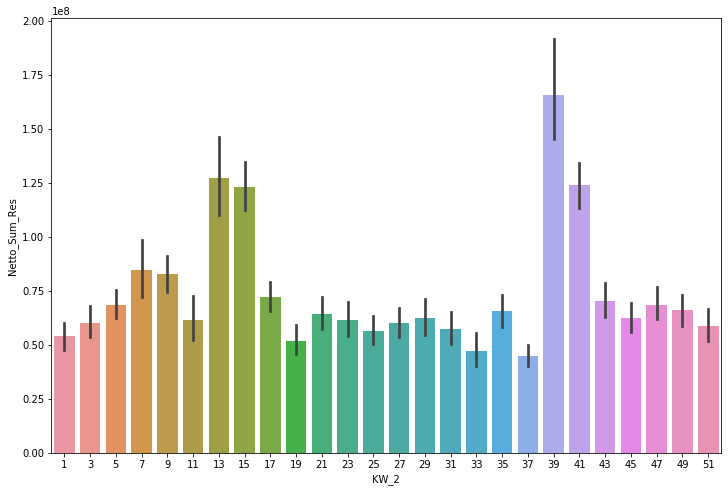

In [565]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=bd_aggr_2w.loc[bd_aggr_2w_complete],
    x="KW_2",
    y="Netto_Sum_Res",
    estimator=np.sum,
)

# Reservations by distance from dispo opening

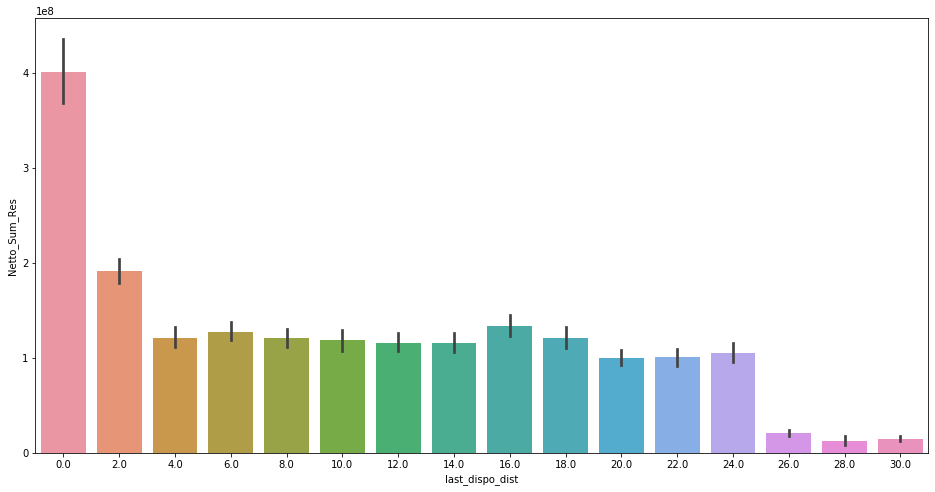

In [574]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.barplot(
    data=bd_aggr_2w.loc[bd_aggr_2w_complete],
    x="last_dispo_dist",
    y="Netto_Sum_Res",
    estimator=np.sum,
)

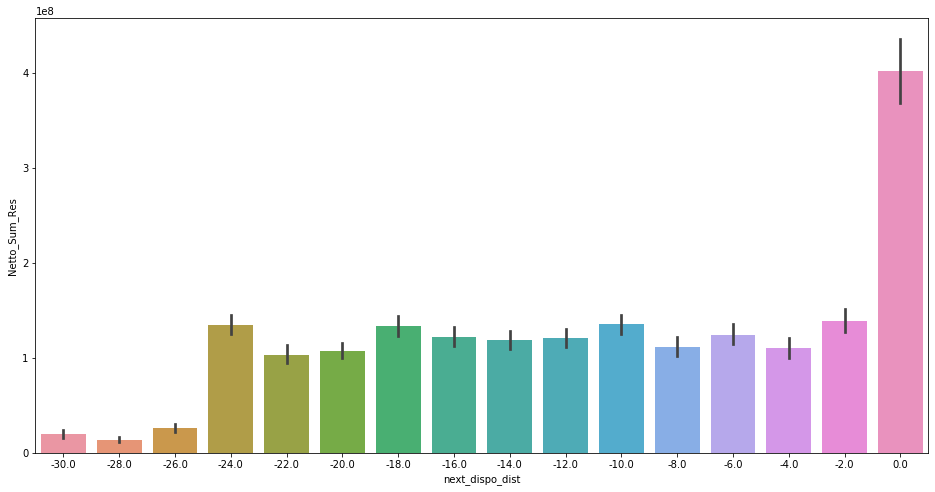

In [575]:
plt.figure(figsize=(16, 8))
sns.barplot(
    data=bd_aggr_2w.loc[bd_aggr_2w_complete],
    x="next_dispo_dist",
    y="Netto_Sum_Res",
    estimator=np.sum,
)

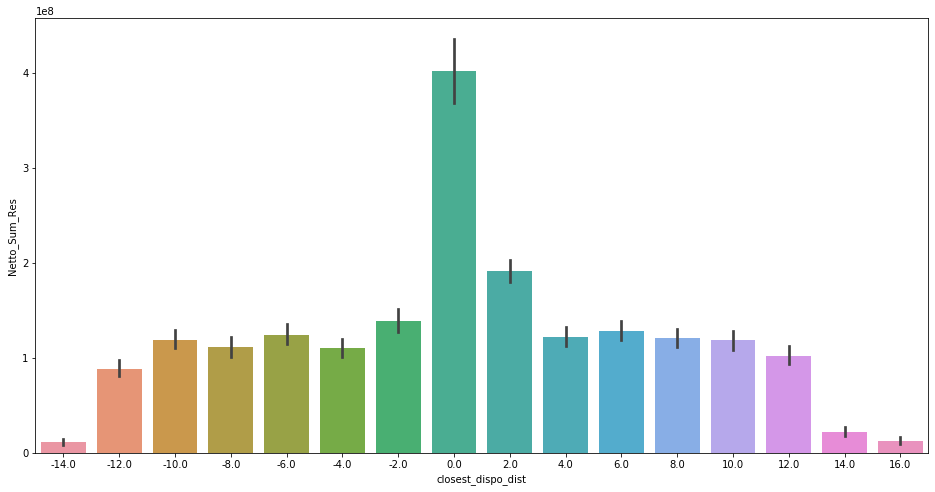

In [576]:
plt.figure(figsize=(16, 8))
sns.barplot(
    data=bd_aggr_2w.loc[bd_aggr_2w_complete],
    x="closest_dispo_dist",
    y="Netto_Sum_Res",
    estimator=np.sum,
)

Distribution of most common dist to closest dispo opening (per customer)

In [679]:
from scipy import stats

def most_common(s):
    return stats.mode(s)[0][0]

def minmax_diff(s):
    return round(s.max() - s.min())

def iqrange(s):
    return round(s.quantile(0.75) - s.quantile(0.25))

from contextlib import contextmanager
@contextmanager
def value(expr):
    yield expr

In [680]:
dists_by_EK = (
    bd_aggr_2w.loc[bd_aggr_2w_complete]
    .groupby("Endkunde_NR")
    .agg({"closest_dispo_dist": [most_common, iqrange, minmax_diff]})
)

12.0    1756
10.0     855
8.0      591
14.0     448
6.0      437
4.0      217
9.0      196
11.0     184
7.0      124
2.0      121
13.0     121
16.0     111
5.0       69
15.0      48
18.0      44
3.0       43
20.0      19
0.0       15
17.0      11
19.0       8
22.0       7
1.0        5
24.0       3
21.0       3
26.0       1
Name: (closest_dispo_dist, iqrange), dtype: int64

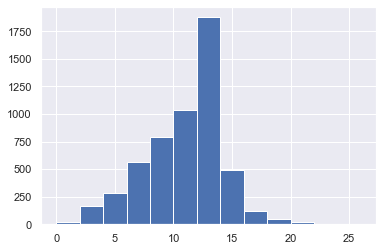

In [681]:
with value(dists_by_EK[("closest_dispo_dist", "iqrange")]) as dists:
    display(dists.value_counts())
    dists.hist(bins=minmax_diff(dists) // 2)

24.0    1102
22.0     876
26.0     862
20.0     858
28.0     602
18.0     548
30.0     515
14.0     334
16.0     308
12.0     172
10.0     108
8.0       93
6.0       76
4.0       37
2.0       25
0.0        3
Name: (closest_dispo_dist, minmax_diff), dtype: int64

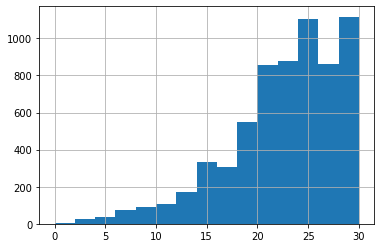

In [584]:
with value(dists_by_EK[("closest_dispo_dist", "minmax_diff")]) as dists:
    display(dists.value_counts())
    dists.hist(bins=minmax_diff(dists) // 2)

In [600]:
netto_by_EK_dist = (
    bd_aggr_2w.loc[bd_aggr_2w_complete]
    .groupby(["Endkunde_NR", "closest_dispo_dist"], observed=True)
    .agg(netto=("Netto_Sum_Res", "sum"))
    .reset_index()
    .pivot_table(
        index="Endkunde_NR",
        columns="closest_dispo_dist",
        values="netto",
        fill_value=0,
        aggfunc="sum",
    )
    .astype("int")
)

prc_by_EK_dist = normalize_rows(netto_by_EK_dist)

In [612]:
prc_by_EK_year_dist = (
    bd_aggr_2w.loc[bd_aggr_2w_complete]
    .groupby(["Endkunde_NR", "Jahr", "closest_dispo_dist"], observed=True)
    .agg(netto=("Netto_Sum_Res", "sum"))
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="closest_dispo_dist",
        values="netto",
        fill_value=0,
        aggfunc="sum",
    )
    .pipe(normalize_rows)
)

prc_by_EK_dist = prc_by_EK_year_dist.groupby("Endkunde_NR").agg("mean")

### Find customers that prefer certain periods relative to dispo opening

-2.0     255
 0.0     216
-6.0     209
 2.0     154
-10.0    141
 6.0      79
-4.0      24
 4.0      24
 12.0     18
-12.0     18
 10.0     15
-8.0      13
 8.0      12
 14.0      2
-14.0      1
 16.0      1
dtype: int64

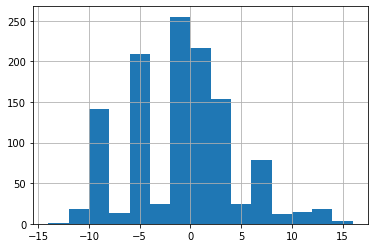

In [620]:
EK_typical_dist = (
    prc_by_EK_dist.where(prc_by_EK_dist > 0.6)
    .dropna(how="all")
    .idxmax(axis="columns")
)

display(EK_typical_dist.value_counts())
EK_typical_dist.hist(bins=minmax_diff(EK_typical_dist) // 2)

# Netto by customer / year

In [625]:
bd_aggr_yr = bd_aggr_2w.groupby(["Endkunde_NR", "Jahr"]).agg(
    {"Netto_Sum_Res": "sum", "Netto_Sum_Aus": "sum"}
)

bd_aggr_yr.head(15)

Netto_Sum_Res  Netto_Sum_Aus
Endkunde_NR Jahr                              
100034      2009        66453.0        66453.0
            2010        72769.0        72769.0
            2011        66019.0        66019.0
            2012        58270.0        58270.0
            2013        37232.0        37232.0
            2014        51182.0        51182.0
            2015        27084.0        27084.0
            2016        36496.0        36496.0
            2017        28648.0        28648.0
            2018        15037.0        15037.0
100039      2009        11970.0         9270.0
            2010         5967.0         5967.0
            2011        15065.0        15960.0
            2012         3500.0         5305.0
            2013        29537.0        29537.0

In [626]:
bd_aggr_yr_ek = bd_aggr_yr.groupby("Endkunde_NR").agg(["min", "max", "mean", "median"])

bd_aggr_yr_ek.head()

Netto_Sum_Res                                 Netto_Sum_Aus  \
                      min      max          mean   median           min   
Endkunde_NR                                                               
100034            15037.0  72769.0  45919.000000  44207.0       15037.0   
100039             3500.0  38960.0  18819.272727  17853.0        5305.0   
100064             1441.0   4155.0   2177.333333   2000.0        1441.0   
100066                0.0   7463.0   2976.666667   1467.0           0.0   
100083                0.0  90123.0  34420.800000  30517.0         880.0   

                                             
                 max          mean   median  
Endkunde_NR                                  
100034       72769.0  45919.000000  44207.0  
100039       38960.0  18819.272727  17853.0  
100064        4155.0   2177.333333   2000.0  
100066        7463.0   2976.666667   1467.0  
100083       54477.0  34420.800000  35646.0

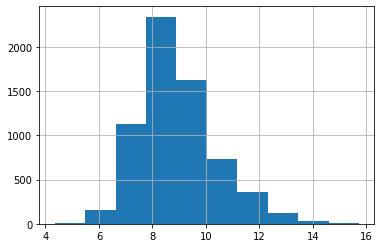

In [627]:
np.log1p(bd_aggr_yr_ek[('Netto_Sum_Res', 'mean')]).hist()

### Find good category borders for 5 categories

In [632]:
pd.qcut(bd_aggr_yr_ek[('Netto_Sum_Res', 'mean')].values, q=5).categories

IntervalIndex([(75.999, 2349.857], (2349.857, 4327.658], (4327.658, 8401.6], (8401.6, 22025.825], (22025.825, 6770657.333]],
              closed='right',
              dtype='interval[float64]')

### Cut the net values, label categories, merge back into ``ek_info_current`` 

In [633]:
_netto_cat = pd.cut(
    bd_aggr_yr_ek[("Netto_Sum_Res", "mean")],
    bins=(0, 4000, 10000, 50000, 500000, 7000000),
    labels="<4k 4k-10k 10k-50k 50k-500k >500k".split(),
).rename("netto_cat")

ek_info_current.loc[:,'Netto_Cat'] = ek_info_current.merge(_netto_cat, on='Endkunde_NR')['netto_cat'].values

In [634]:
ek_info_current.Netto_Cat.value_counts()

<4k         2448
4k-10k      1759
10k-50k     1632
50k-500k     609
>500k         71
Name: Netto_Cat, dtype: int64

# Calculate sum curve per customer * year, over periods

In [635]:
def make_year_grp_sumcurve(df, year_col, grp_col, data_col, prefix=""):
    # build new columns with sum/cumsum per year/grp
    df = df.pipe(
        calc_col_partitioned,
        f"{prefix}sumJahr",
        fun="sum",
        on=data_col,
        part_by=[year_col, grp_col],
    ).pipe(
        calc_col_partitioned,
        f"{prefix}cumJahr",
        fun="cumsum",
        on=data_col,
        part_by=[year_col, grp_col],
    )

    # divide data_col by sum to get scaled amounts, show in %
    df = (
        df.eval(f"{prefix}prcJahr = ({data_col} / {prefix}sumJahr) * 100 + 0.5")
        .fillna({f"{prefix}prcJahr": 0})
        .astype({f"{prefix}prcJahr": "int"})
    )

    # divide cumsum by sum to get sum curve [0, 1], show in %
    df = (
        df.eval(f"{prefix}crvJahr = ({prefix}cumJahr / {prefix}sumJahr) * 100 + 0.5")
        .fillna({f"{prefix}crvJahr": 0})
        .astype({f"{prefix}crvJahr": "int"})
    )
    return df

In [636]:
bd_aggr_2w = (
    bd_aggr_2w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_2"])
    .reset_index(drop=True)
)

bd_aggr_4w = (
    bd_aggr_4w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_4"])
    .reset_index(drop=True)
)

In [656]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus,KAM_Kunde,closest_dispo_dist,last_dispo_dist,next_dispo_dist,Res_sumJahr,Res_cumJahr,Res_prcJahr,Res_crvJahr,Aus_sumJahr,Aus_cumJahr,Aus_prcJahr,Aus_crvJahr
0,100034,2009,7,21834.0,0.0,0,-8.0,18.0,-8.0,66453.0,21834.0,33,33,66453.0,0.0,0,0
1,100034,2009,9,1400.0,0.0,0,-6.0,20.0,-6.0,66453.0,23234.0,2,35,66453.0,0.0,0,0
2,100034,2009,13,0.0,23234.0,0,-2.0,24.0,-2.0,66453.0,23234.0,0,35,66453.0,23234.0,35,35
3,100034,2009,17,3933.0,0.0,0,2.0,2.0,-24.0,66453.0,27167.0,6,41,66453.0,23234.0,0,35
4,100034,2009,23,0.0,3933.0,0,8.0,8.0,-18.0,66453.0,27167.0,0,41,66453.0,27167.0,6,41
5,100034,2009,39,9000.0,0.0,0,-2.0,24.0,-2.0,66453.0,36167.0,14,54,66453.0,27167.0,0,41
6,100034,2009,43,3770.0,9000.0,0,2.0,2.0,-24.0,66453.0,39937.0,6,60,66453.0,36167.0,14,54
7,100034,2009,45,26516.0,0.0,0,4.0,4.0,-22.0,66453.0,66453.0,40,100,66453.0,36167.0,0,54
8,100034,2009,47,0.0,30286.0,0,6.0,6.0,-20.0,66453.0,66453.0,0,100,66453.0,66453.0,46,100
9,100034,2010,9,22495.0,0.0,0,-6.0,20.0,-6.0,72769.0,22495.0,31,31,72769.0,0.0,0,0


In [638]:
bd_aggr_4w.head(10)

,Endkunde_NR,Jahr,KW_4,Netto_Sum_Res,Netto_Sum_Aus,Res_sumJahr,Res_cumJahr,Res_prcJahr,Res_crvJahr,Aus_sumJahr,Aus_cumJahr,Aus_prcJahr,Aus_crvJahr
0,100034,2009,5,21834.0,0.0,66453.0,21834.0,33,33,66453.0,0.0,0,0
1,100034,2009,9,1400.0,0.0,66453.0,23234.0,2,35,66453.0,0.0,0,0
2,100034,2009,13,0.0,23234.0,66453.0,23234.0,0,35,66453.0,23234.0,35,35
3,100034,2009,17,3933.0,0.0,66453.0,27167.0,6,41,66453.0,23234.0,0,35
4,100034,2009,21,0.0,3933.0,66453.0,27167.0,0,41,66453.0,27167.0,6,41
5,100034,2009,37,9000.0,0.0,66453.0,36167.0,14,54,66453.0,27167.0,0,41
6,100034,2009,41,3770.0,9000.0,66453.0,39937.0,6,60,66453.0,36167.0,14,54
7,100034,2009,45,26516.0,30286.0,66453.0,66453.0,40,100,66453.0,66453.0,46,100
8,100034,2010,9,22495.0,0.0,72769.0,22495.0,31,31,72769.0,0.0,0,0
9,100034,2010,13,0.0,22495.0,72769.0,22495.0,0,31,72769.0,22495.0,31,31


### Store and reload results

In [657]:
store_bin(bd_aggr_2w, 'bd_cluster_aggr_2w.feather')
store_bin(bd_aggr_4w, 'bd_cluster_aggr_4w.feather')

2019-09-19 14:43:55 [INFO] Writing to file C:\Users\kpf\data\vkprog\bd_cluster_aggr_2w.feather
INFO:pa_log:Writing to file C:\Users\kpf\data\vkprog\bd_cluster_aggr_2w.feather
2019-09-19 14:43:55 [INFO] Written 21.0 MB
INFO:pa_log:Written 21.0 MB
2019-09-19 14:43:55 [INFO] Finished storing binary file in 0.02s (0.14s CPU)
INFO:pa_log:Finished storing binary file in 0.02s (0.14s CPU)
2019-09-19 14:43:55 [INFO] Writing to file C:\Users\kpf\data\vkprog\bd_cluster_aggr_4w.feather
INFO:pa_log:Writing to file C:\Users\kpf\data\vkprog\bd_cluster_aggr_4w.feather
2019-09-19 14:43:55 [INFO] Written 12.1 MB
INFO:pa_log:Written 12.1 MB
2019-09-19 14:43:55 [INFO] Finished storing binary file in 0.02s (0.09s CPU)
INFO:pa_log:Finished storing binary file in 0.02s (0.09s CPU)


In [658]:
bd_aggr_2w = load_bin('bd_cluster_aggr_2w.feather')
bd_aggr_4w = load_bin('bd_cluster_aggr_4w.feather')

2019-09-19 14:43:57 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_cluster_aggr_2w.feather
INFO:pa_log:Reading from file C:\Users\kpf\data\vkprog\bd_cluster_aggr_2w.feather
2019-09-19 14:43:57 [INFO] Finished loading binary file in 0.01s (0.02s CPU)
INFO:pa_log:Finished loading binary file in 0.01s (0.02s CPU)
2019-09-19 14:43:57 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_cluster_aggr_4w.feather
INFO:pa_log:Reading from file C:\Users\kpf\data\vkprog\bd_cluster_aggr_4w.feather
2019-09-19 14:43:57 [INFO] Finished loading binary file in 0.01s (0.0s CPU)
INFO:pa_log:Finished loading binary file in 0.01s (0.0s CPU)


# Clustering Customers by Reservation

### Pivot prc values by period

In [642]:
bd_res_prc_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(complete_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_prcJahr",
        aggfunc="sum",
    )
    .dropna(how="all")
    .fillna(0)
)

bd_res_prc_2w_data.head(12)

KW_2                1     3     5     7     9    11    13   15    17   19  \
Endkunde_NR Jahr                                                            
100034      2009   0.0   0.0   0.0  33.0   2.0  0.0   0.0  0.0   6.0  0.0   
            2010   0.0   0.0   0.0   0.0  31.0  0.0   0.0  0.0   0.0  0.0   
            2011   0.0   0.0   0.0   0.0  40.0  0.0   0.0  0.0   0.0  0.0   
            2012   0.0   0.0   0.0   0.0  29.0  0.0   0.0  0.0   0.0  0.0   
            2013   0.0   0.0  52.0   2.0   0.0  0.0   0.0  0.0   0.0  0.0   
            2014   0.0  40.0   2.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   
            2015   0.0   0.0  44.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   
            2016   0.0  57.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   
            2017   0.0   0.0  28.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   
            2018   0.0   0.0  26.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   
100039      2009  23.0   0.0   0.0   0.0   0.0  0.0  55.0  0.0   0.0  0.0   
            2010   0.0   0.0   0.0   0.0   0.0  0.0   0.0  0.0  55.0  0.0   

KW_2               21   23   25   27    29    31   33   35   37    39    41  \
Endkunde_NR Jahr                                                              
100034      2009  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  14.0   0.0   
            2010  0.0  0.0  0.0  0.0  12.0   0.0  0.0  0.0  0.0   0.0   0.0   
            2011  0.0  0.0  0.0  0.0   0.0  14.0  0.0  0.0  0.0   4.0   2.0   
            2012  0.0  0.0  0.0  0.0   8.0   9.0  0.0  0.0  0.0   0.0   0.0   
            2013  0.0  0.0  0.0  0.0   0.0  14.0  0.0  0.0  0.0   0.0   0.0   
            2014  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
            2015  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
            2016  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  39.0   
            2017  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0  26.0   
            2018  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
100039      2009  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
            2010  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   

KW_2                43    45   47   49    51  
Endkunde_NR Jahr                              
100034      2009   6.0  40.0  0.0  0.0   0.0  
            2010  57.0   0.0  0.0  0.0   0.0  
            2011  41.0   0.0  0.0  0.0   0.0  
            2012  51.0   2.0  0.0  0.0   0.0  
            2013  32.0   0.0  0.0  0.0   0.0  
            2014  58.0   0.0  0.0  0.0   0.0  
            2015  51.0   5.0  0.0  0.0   0.0  
            2016   4.0   0.0  0.0  0.0   0.0  
            2017  47.0   0.0  0.0  0.0   0.0  
            2018  74.0   0.0  0.0  0.0   0.0  
100039      2009   0.0   0.0  0.0  0.0  23.0  
            2010   0.0   0.0  0.0  0.0  45.0

### Prepare data: Aggregate over years by customer

In [643]:
ek_2w_prc_mean = (
    bd_res_prc_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

# correct rowsums to 100
ek_2w_prc_mean = normalize_rows(ek_2w_prc_mean) * 100

ek_2w_prc_mean_stack = (
    ek_2w_prc_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "prc_mean"], axis="columns", inplace=False)
)

display(ek_2w_prc_mean.round(1).head(10))

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0.0,9.7,15.2,3.5,10.2,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,2.0,3.7,0.0,0.0,0.0,1.8,6.7,42.0,4.7,0.0,0.0,0.0
100039,2.3,5.3,0.0,0.0,4.2,8.8,11.2,8.5,5.5,0.0,0.0,3.1,0.0,0.0,0.0,8.9,0.0,16.8,0.0,0.0,0.0,0.0,12.7,2.6,2.2,8.0
100064,0.0,0.0,0.0,0.0,11.1,0.0,83.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0
100083,12.4,0.0,0.0,33.4,0.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,33.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.1
100095,0.0,0.0,1.8,22.3,9.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.9,31.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4,0.0,7.2,0.0,3.2,11.6,0.0,0.0,26.1,7.6,3.0,14.8,20.0,0.0
100098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
100104,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,79.9,3.7,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pivot crv values by period

In [644]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[bd_aggr_2w_complete]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

### Aggregate over years by customer

In [645]:
ek_2w_crv_mean = (
    bd_res_crv_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_crv_mean_stack = (
    ek_2w_crv_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "crv_mean"], axis="columns", inplace=False)
)

display(bd_res_crv_2w_data.head())
display(ek_2w_crv_mean.head())
ek_2w_crv_mean_stack.head()

KW_2               1    3    5    7    9    11   13   15   17   19     21  \
Endkunde_NR Jahr                                                            
100369      2017  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
            2018  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
            2019  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
100371      2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
            2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  100.0   

KW_2                 23     25     27     29     31     33     35     37  \
Endkunde_NR Jahr                                                           
100369      2017    0.0    0.0    0.0    0.0    0.0    0.0  100.0  100.0   
            2018    0.0    0.0    0.0   24.0   24.0   24.0   24.0   24.0   
            2019  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
100371      2008    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
            2010  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   

KW_2                 39     41     43     45     47     49     51  
Endkunde_NR Jahr                                                   
100369      2017  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
            2018   24.0   24.0   24.0   24.0  100.0  100.0  100.0  
            2019  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
100371      2008    0.0    0.0  100.0  100.0  100.0  100.0  100.0  
            2010  100.0  100.0  100.0  100.0  100.0  100.0  100.0

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,
100369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.333333,33.333333,33.333333,41.333333,41.333333,41.333333,74.666667,74.666667,74.666667,74.666667,74.666667,74.666667,100.000000,100.000000,100.0
100371,2.571429,3.571429,3.571429,4.857143,12.285714,12.285714,14.000000,15.142857,15.142857,15.142857,30.285714,30.285714,33.000000,34.428571,40.714286,41.571429,42.857143,44.428571,44.428571,47.000000,56.714286,85.285714,92.857143,92.857143,93.714286,100.0
100373,1.285714,5.142857,13.000000,16.428571,21.571429,23.285714,24.571429,29.571429,32.571429,32.571429,32.571429,32.571429,49.857143,52.000000,55.142857,61.714286,64.142857,68.714286,68.714286,72.571429,76.000000,82.142857,95.571429,100.000000,100.000000,100.0
100375,0.000000,0.000000,2.428571,6.285714,10.000000,10.000000,27.571429,50.857143,50.857143,50.857143,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,67.142857,71.428571,85.714286,100.0
100384,1.666667,4.416667,4.916667,4.916667,10.333333,10.333333,12.000000,29.916667,29.916667,31.333333,32.916667,41.250000,44.166667,44.916667,46.583333,46.583333,47.166667,47.333333,47.333333,52.833333,80.000000,87.333333,94.666667,98.083333,100.000000,100.0


,Endkunde_NR,KW_2,crv_mean
0,100369,1,0.0
1,100369,3,0.0
2,100369,5,0.0
3,100369,7,0.0
4,100369,9,0.0


### Plot customer booking patterns (global)

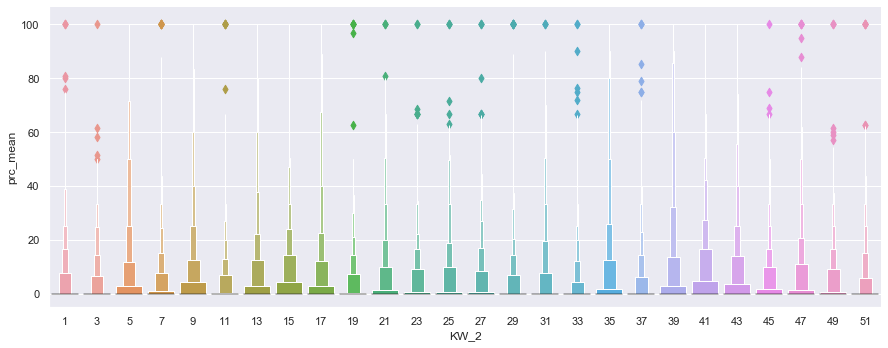

In [646]:
import seaborn as sns
%matplotlib inline

sns.set()
sns.catplot(
    data=ek_2w_prc_mean_stack, x="KW_2", y="prc_mean", aspect=2.5, kind="boxen"
)

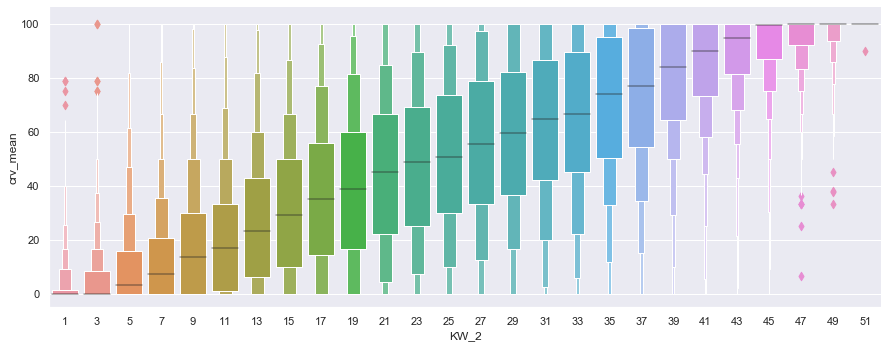

In [647]:
sns.catplot(
    data=ek_2w_crv_mean_stack, x="KW_2", y="crv_mean", aspect=2.5, kind="boxen"
)

### Cluster booking patterns (percentage of yearly sum)

Prepare data

In [648]:
X = ek_2w_prc_mean.to_numpy()

X_columns = ek_2w_prc_mean.columns

#### Normal KMeans

In [649]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [650]:
for n_clusters in range(5, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 5: Silhouette_score = 0.17760134359298146,  CH score = 501.4412458034421
For n_clusters = 6: Silhouette_score = 0.15211960723185067,  CH score = 498.05186312556555
For n_clusters = 7: Silhouette_score = 0.14925678817082974,  CH score = 519.7414680536932
For n_clusters = 8: Silhouette_score = 0.1646565431474314,  CH score = 527.05043115977
For n_clusters = 9: Silhouette_score = 0.17216753104861768,  CH score = 516.180996154673
For n_clusters = 10: Silhouette_score = 0.18027927554464576,  CH score = 524.6267114664272
For n_clusters = 11: Silhouette_score = 0.19148048748363872,  CH score = 543.2519006964185
For n_clusters = 12: Silhouette_score = 0.19849877259765414,  CH score = 542.8505309105525
For n_clusters = 13: Silhouette_score = 0.21342360808743568,  CH score = 559.3245630399518
For n_clusters = 14: Silhouette_score = 0.20351703871079144,  CH score = 562.3867682517781
For n_clusters = 15: Silhouette_score = 0.2143271800389966,  CH score = 571.6913330690176
For n_cl

In [651]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

prc_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

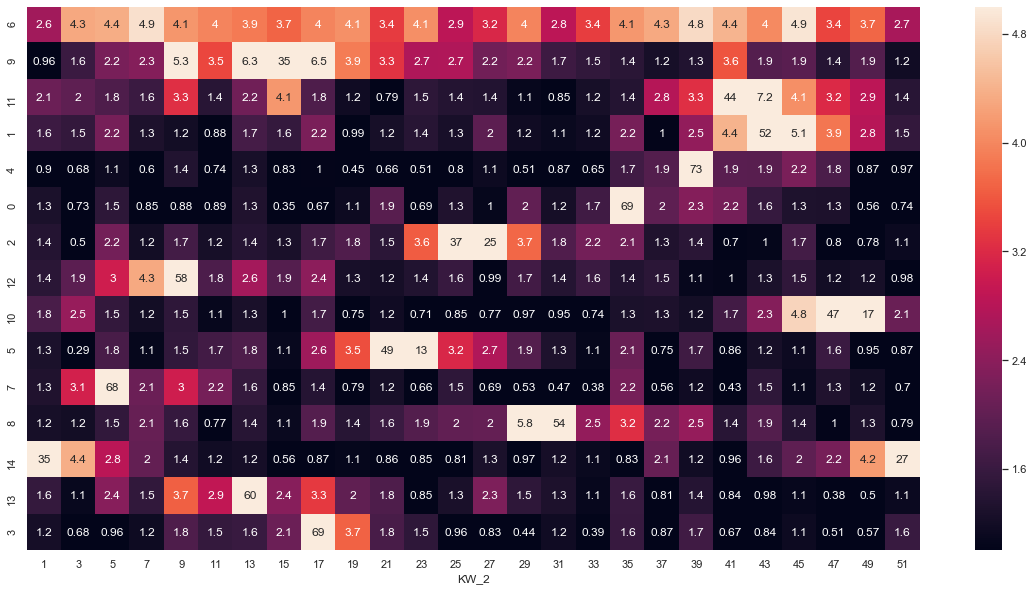

In [652]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True, vmin=1, vmax=5)

Cluster sizes

In [653]:
pd.Series(prc_nkmeans_labels).value_counts()

6     2526
9      470
11     450
1      310
4      294
0      277
2      274
12     261
10     260
5      255
7      239
8      236
14     233
13     230
3      204
dtype: int64

Plot scaled bookings by cluster

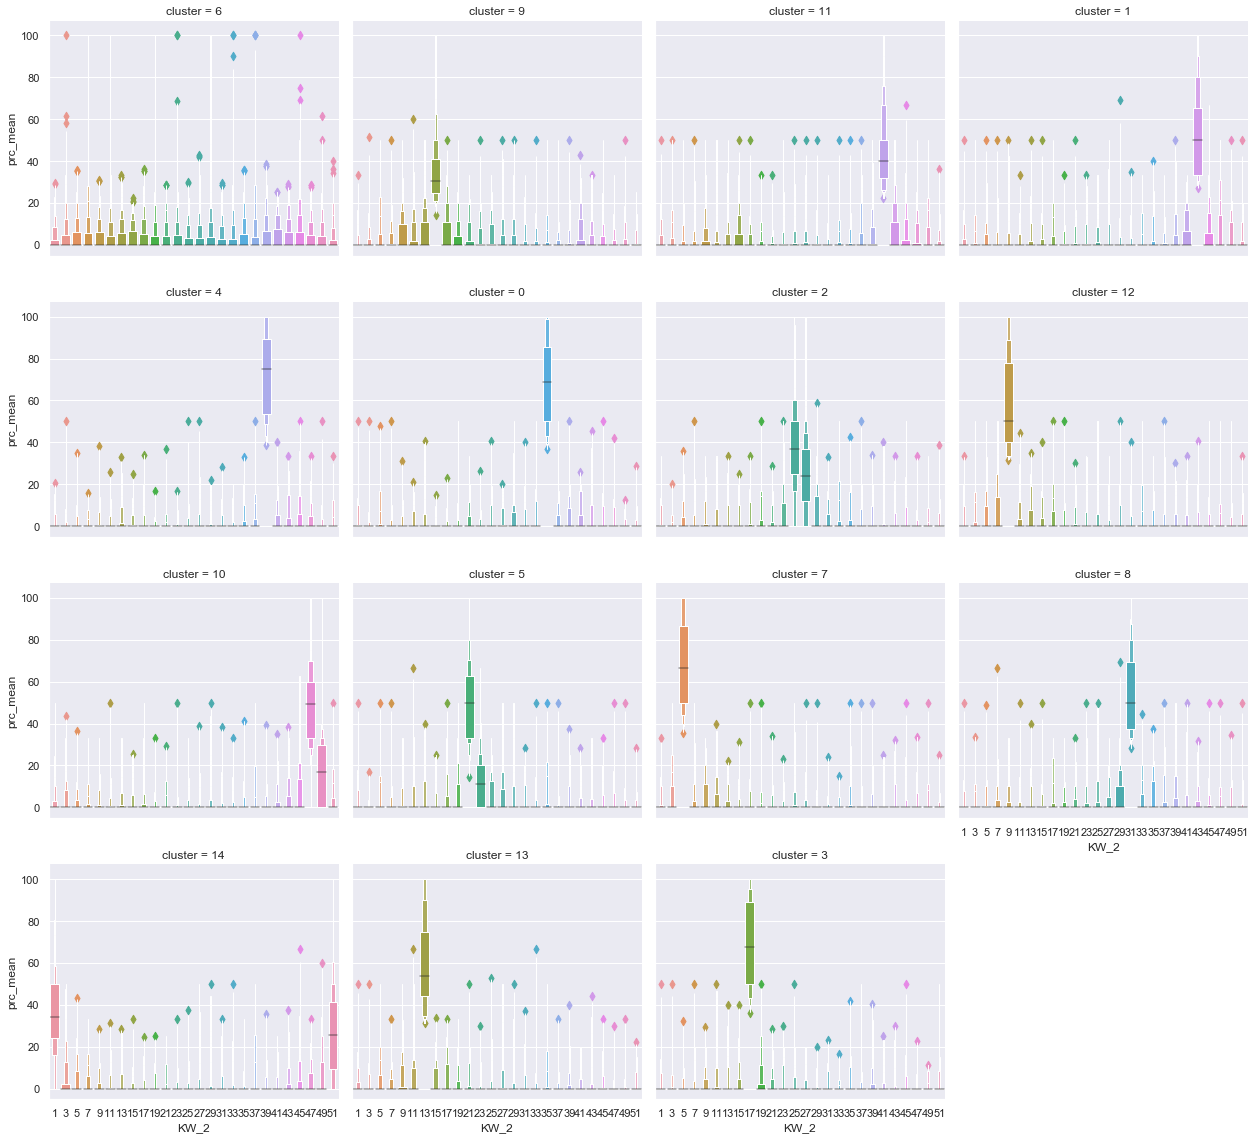

In [654]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=prc_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.1,
    kind="boxen",
    col="cluster",
    col_wrap=4,
    col_order=pd.Series(prc_nkmeans_labels).value_counts().index,  # order by cluster size
    height=4,
)

### Cluster booking patterns (cumulative percentage of yearly sum)

Prepare data

In [ ]:
X = ek_2w_crv_mean.to_numpy()

X_columns = ek_2w_crv_mean.columns

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(3, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

crv_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(crv_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True)

Cluster sizes

In [ ]:
pd.Series(crv_nkmeans_labels).value_counts()

Plot scaled bookings by cluster

In [ ]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=crv_nkmeans_labels, index=ek_2w_crv_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    col_order=pd.Series(crv_nkmeans_labels).value_counts().index, # order by cluster size
    height=4,
)

### Cluster booking patterns (percentage of yearly sum) relative to dispo openings

Prepare data

In [670]:
X = prc_by_EK_dist.to_numpy()

X_columns = prc_by_EK_dist.columns

#### Normal KMeans

In [660]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [662]:
for n_clusters in range(3, 11):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 3: Silhouette_score = 0.13874497524393278,  CH score = 850.4637726346418
For n_clusters = 4: Silhouette_score = 0.1714846876939481,  CH score = 937.6297613399214
For n_clusters = 5: Silhouette_score = 0.18901937122658788,  CH score = 968.6581859765363
For n_clusters = 6: Silhouette_score = 0.20704986634609235,  CH score = 1011.1086620280572
For n_clusters = 7: Silhouette_score = 0.21540652095634236,  CH score = 1030.6693543291112
For n_clusters = 8: Silhouette_score = 0.2158788179679881,  CH score = 1020.3233964454025
For n_clusters = 9: Silhouette_score = 0.20782906413860253,  CH score = 973.9298842430437
For n_clusters = 10: Silhouette_score = 0.2064350281670999,  CH score = 926.1098154197165


In [663]:
nkmeans = KMeans(n_clusters=7, random_state=0, verbose=1, n_jobs=-1)

prc_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

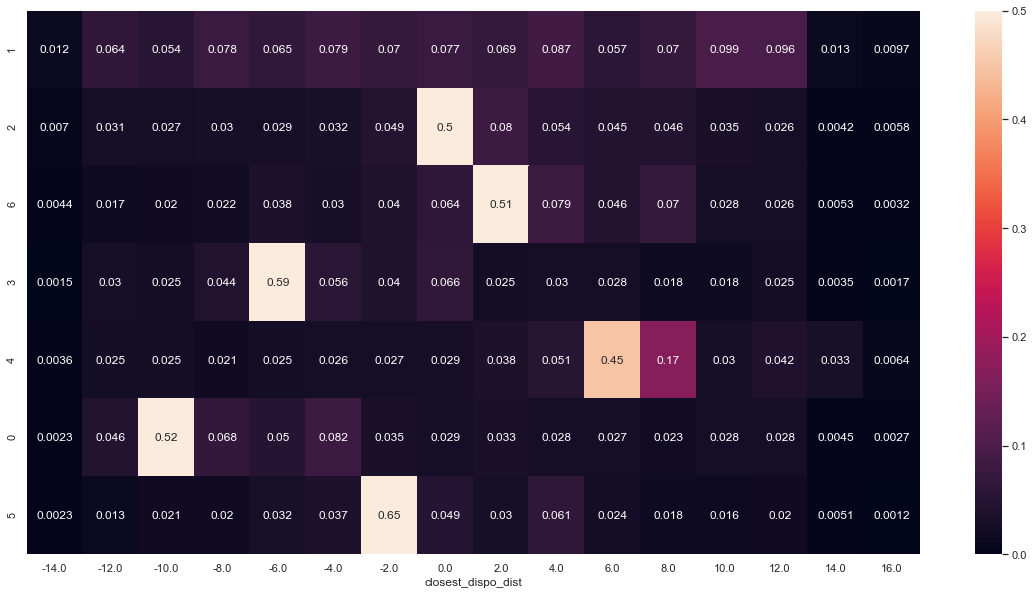

In [677]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True, vmin=0, vmax=0.5)

Cluster sizes

In [673]:
pd.Series(prc_nkmeans_labels).value_counts()

1    2908
2     918
6     623
3     541
4     527
0     518
5     484
dtype: int64

Plot scaled bookings by cluster

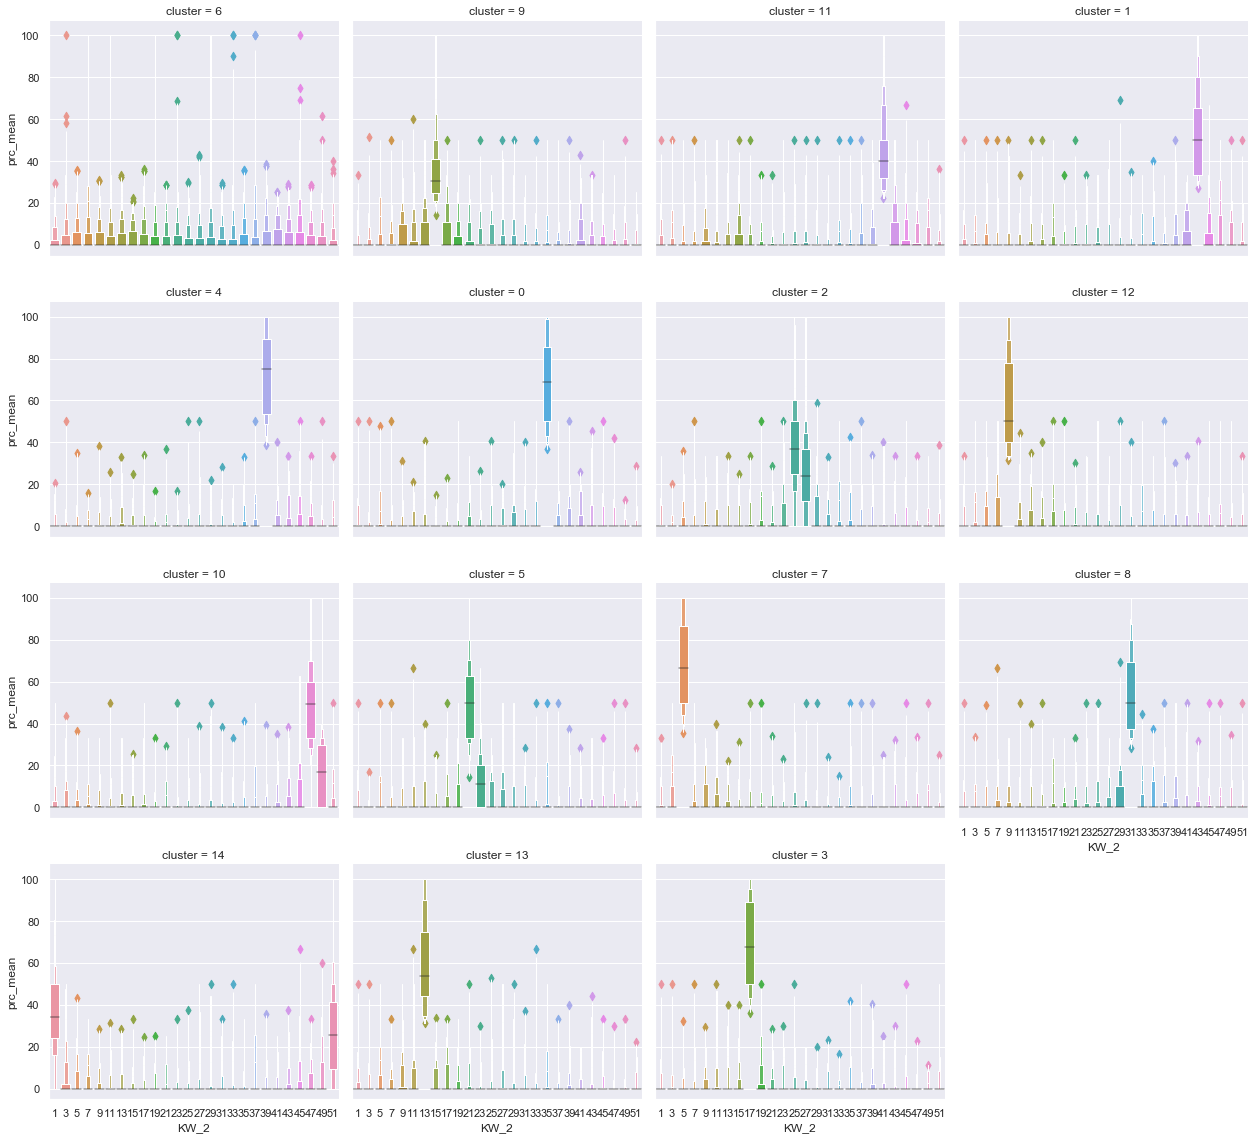

In [654]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=prc_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.1,
    kind="boxen",
    col="cluster",
    col_wrap=4,
    col_order=pd.Series(prc_nkmeans_labels).value_counts().index,  # order by cluster size
    height=4,
)

# PCA on Customers

### Prepare Data

In [ ]:
X = ek_2w_crv_mean.to_numpy()
X_columns = ek_2w_crv_mean.columns
X_index = ek_2w_crv_mean.index

y = crv_nkmeans_labels

### Calculate standard PCA with 4 components

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, random_state=0)
X_pca = pca.fit_transform(X)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.components_

### Plot K-means clusters against principal components

In [ ]:
plot_data = pd.DataFrame(X_pca, index=X_index, columns=range(1, pca.n_components + 1))
plot_data["clusters"] = y
sns.set(style="ticks")
sns.pairplot(data=plot_data, hue="clusters", plot_kws={"alpha": 0.4})

# Clustering Customer Booking Years

### Prepare data: Pivot prc values by period

In [ ]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data_stack = bd_res_prc_2w_data.stack()

bd_res_prc_2w_data.head(12)

In [ ]:
X = bd_res_prc_2w_data.to_numpy()

X_columns = bd_res_prc_2w_data.columns
X_index = bd_res_prc_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(25, 31):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_prc_nkmeans_labels = nkmeans.fit_predict(X)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_prc_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(yr_prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(25, 16))
sns.heatmap(yr_prc_nkmeans_clusters, annot=True, vmin=0, vmax=7)

In [ ]:
pd.Series(yr_prc_nkmeans_labels).value_counts() # / yr_prc_nkmeans_labels.shape[0]

In [ ]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [ ]:
ek_prc_cls = pd.crosstab(
    index=bd_res_prc_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_prc_nkmeans_labels, name="cluster"),
)

ek_prc_cls_yr_cnt_ = ek_prc_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_prc_cls = ek_prc_cls.assign(
    n_yr=ek_prc_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_prc_cls_yr_cnt_.where(ek_prc_cls > 0).count(axis="columns"),
    cls=ek_prc_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_prc_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_prc_cls["n_main_cls"] = ek_prc_cls["main_cls"].apply(len)

ek_prc_cls

### Customers that can be related to 1 or 2 clusters

In [ ]:
max_main_cls = 2

ek_clust_scoring = ek_prc_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

### Prepare data: Pivot crv values by period

In [ ]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

bd_res_crv_2w_data_stack = bd_res_crv_2w_data.stack()

bd_res_crv_2w_data.head(12)

### Prepare for clustering

In [ ]:
X = bd_res_crv_2w_data.to_numpy()

X_columns = bd_res_crv_2w_data.columns
X_index = bd_res_crv_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in [15, 25, 35, 40]:
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

```
For n_clusters = 5: Silhouette_score = 0.3049945347740261,  CH score = 29630.89896114061
For n_clusters = 10: Silhouette_score = 0.366230862992324,  CH score = 26973.062027368196
For n_clusters = 15: Silhouette_score = 0.40334656127747526,  CH score = 25417.006073311764
For n_clusters = 20: Silhouette_score = 0.44202548618962784,  CH score = 24818.708849953175
For n_clusters = 25: Silhouette_score = 0.5033501558327148,  CH score = 24748.31007457299
For n_clusters = 30: Silhouette_score = 0.5602936199726821,  CH score = 25025.39923837368
For n_clusters = 35: Silhouette_score = 0.6095264482491675,  CH score = 26642.345879735167
For n_clusters = 40: Silhouette_score = 0.6171105582735361,  CH score = 26586.30470955651
```

In [ ]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_crv_nkmeans_labels = nkmeans.fit_predict(X)

### Show cluster centroids

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns)

plt.figure(figsize=(25, 16))
sns.heatmap(yr_nkmeans_clusters, annot=True, vmin=5)

### Cluster sizes

In [ ]:
pd.Series(yr_crv_nkmeans_labels).value_counts()

In [ ]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_crv_nkmeans_labels, index=bd_res_crv_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [ ]:
ek_cls = pd.crosstab(
    index=bd_res_crv_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_crv_nkmeans_labels, name="cluster"),
)

ek_cls_yr_cnt_ = ek_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_cls = ek_cls.assign(
    n_yr=ek_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_cls_yr_cnt_.where(ek_cls > 0).count(axis="columns"),
    cls=ek_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_cls["n_main_cls"] = ek_cls["main_cls"].apply(len)

ek_cls

### Customers that can be assigned to 1 or 2 clusters

In [ ]:
max_main_cls = 2

yr_clust_scoring = ek_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

# Compare scoring between customer layer and year layer

In [ ]:
len(np.unique(ek_clust_scoring.index.values))

In [ ]:
len(np.unique(yr_clust_scoring.index.values))

In [ ]:
pd.DataFrame({"ek": np.unique(ek_clust_scoring.index.values)}).merge(
    pd.DataFrame({"ek": np.unique(yr_clust_scoring.index.values)}),
    how="outer",
    on="ek",
    indicator=True,
)["_merge"].value_counts()

# Cluster Scoring vs. Auftragsart

In [ ]:
AufArt_Clust = (
    ek_auftragsart_scoring.merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust)

In [ ]:
plt.figure(figsize=(16, 20))
sns.heatmap(
    data=np.log1p(pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust)),
    annot=pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust),
    fmt="d"
)

# Cluster Scoring vs. Branchengruppe

In [ ]:
BG_Clust = (
    ek_branchen_scoring.merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG, margins=True)

In [ ]:
plt.figure(figsize=(16, 32))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG)),
    annot=pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG),
    fmt="d",
    vmax=0.4
)

# Cluster Scoring vs. Kanton

In [ ]:
with project_dir('Raumgliederung'):
    ek_region = load_bin('ek_region.feather')

In [ ]:
ek_region.head()

In [ ]:
Kt_Clust = (
    ek_region[["Endkunde_NR", "KANTON"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Kt_Clust.Clust, index=Kt_Clust.KANTON)),
    annot=pd.crosstab(columns=Kt_Clust.Clust, index=Kt_Clust.KANTON),
    fmt="d",
    #vmax=0.4
)

# Cluster Scoring vs. Grossregion

In [ ]:
GrReg_Clust = (
    ek_region[["Endkunde_NR", "GROSSREGION"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=GrReg_Clust.Clust, index=GrReg_Clust.GROSSREGION)),
    annot=pd.crosstab(columns=GrReg_Clust.Clust, index=GrReg_Clust.GROSSREGION),
    fmt="d",
)

# Cluster Scoring vs. Region

In [ ]:
Reg_Clust = (
    ek_region[["Endkunde_NR", "REGION"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 32))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Reg_Clust.Clust, index=Reg_Clust.REGION)),
    annot=pd.crosstab(columns=Reg_Clust.Clust, index=Reg_Clust.REGION),
    fmt="d",
)

# Cluster Scoring vs. Netto-Umsatz

In [ ]:
Netto_Clust = (
    ek_info_current[["Endkunde_NR", "netto_cat"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Netto_Clust.Clust, index=Netto_Clust.netto_cat)),
    annot=pd.crosstab(columns=Netto_Clust.Clust, index=Netto_Clust.netto_cat),
    fmt="d",
)

# Map cluster scorings to periods, where appropriate

## Years, clustered by prc

In [ ]:
ek_clusters = (pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="yr_prc_clust"
        ),
        on=["Endkunde_NR", "Jahr"],
    ))

ek_clusters.head()